In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import janitor
from opendatasets import download
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

### 1. Extracting and cleaning data

Breast cancer was studied by fine needle aspirate (FNA) of a breast mass experiments, they describe characteristics of the cell nuclei present in the image. Features as `radius_mean`, and `concavity` can influence the odds of presenting a _malign_ breast tumoral tissue. In this project, we will harness on logistic regression to predict `diagnosis` of an individual given several features as presented in this study based on FNA. 

FNA involves the study of following parameters:

`a)` radius (mean of distances from center to points on the perimeter)

`b)` texture (standard deviation of gray-scale values) 

`c)` perimeter

`d)` area

`e)` smoothness (local variation in radius lengths)

`f)` compactness (perimeter^2 / area - 1.0)

`g)` concavity (severity of concave portions of the contour)

`h)` concave points (number of concave portions of the contour)

`i)` symmetry

`j)` fractal dimension ("coastline approximation" - 1)

_The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features._

In [4]:
# download("https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data", data_dir="./data/breast_cancer") # This function downloads our dataset in data_dir, this was already done.

In [5]:
raw_df = pd.read_csv("./data/breast_cancer/data.csv", header=0, sep=",")
raw_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [6]:
raw_df.dtypes.value_counts() # There is only a categorical variable, and this is precisely diagnosis

float64    31
int64       1
object      1
dtype: int64

In [7]:
raw_df.shape

(569, 33)

In [8]:
raw_df.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [9]:
raw_df.drop("id", axis=1, inplace=True)

In [10]:
raw_df.describe()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [11]:
%run "./utils/pandas-missing-extension.ipynb"

In [12]:
raw_df.missing.missing_variable_summary().sort_values(ascending=False, by="n_missing").head()

,variable,n_missing,n_cases,pct_missing
31,Unnamed: 32,569,569,100.0
0,diagnosis,0,569,0.0
2,texture_mean,0,569,0.0
1,radius_mean,0,569,0.0
4,area_mean,0,569,0.0


In [13]:
df = raw_df.copy()
df.drop("Unnamed: 32", axis=1, inplace=True)

In [14]:
df.missing.number_missing()

0

### 2.  Undersampling

A key step in model training is to size and standardize our target values in order to get non-biased predictors could give more weight to one of the classes to predict. A wrap up of categorical variable `diagnosis` is necessary to assess this:

In [15]:
count_cat = df.diagnosis.value_counts().reset_index().rename(columns={"index" : "diagnosis", "diagnosis": "count"})
count_cat

,diagnosis,count
0,B,357
1,M,212


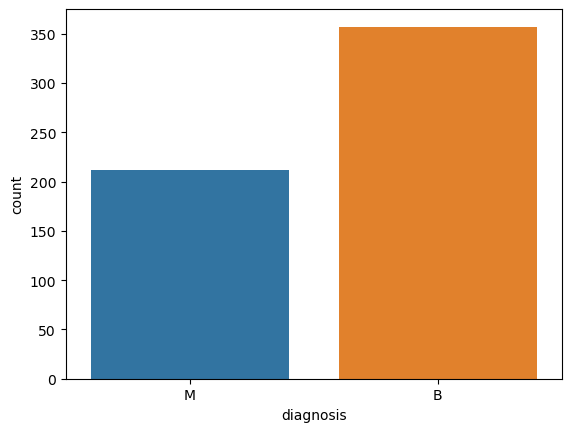

In [16]:
sns.countplot(data=df, x="diagnosis")
plt.show()

_benign_ results show to be 1.68 times more populated respect to _malign_ class, despite there is not a high bias towards _benign_, model will be evaluated for _undersampling_ and non _undersampling_ standardization methods.

Starting with _undersampling_, we have to import the following library:

In [17]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)

In [18]:
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

In [19]:
X_under, y_under = undersample.fit_resample(X, y)

In [20]:
print(f"The loss of data is equivalent to {X.shape[0] - X_under.shape[0]} rows, which makes a {(X.shape[0] - X_under.shape[0])/ X.shape[0]:.2f} fraction of total data")

The loss of data is equivalent to 145 rows, which makes a 0.25 fraction of total data


In [21]:
y_under.value_counts().reset_index().rename(columns={"index" : "diagnosis", "diagnosis": "count"})

,diagnosis,count
0,B,212
1,M,212


Now, we have resampled data respect to `diagnosis`.

### 3. Conversion to numerical

Our target value is currently labelled as categorical string values, in order to use `LogisticRegression()`, we should make sure that values are encoded in discrete values:

In [22]:
y_under.replace({"B" : 0, "M" : 1}, inplace=True)

In [23]:
y_under.value_counts().reset_index().rename(columns={"index" : "diagnosis", "diagnosis": "count"})

,diagnosis,count
0,0,212
1,1,212


### 4. Exploratory data analysis

In this paramount step, besides of determine more relevant information about our dataset, we can find with colinear variables which can add up errors or overfitting to our model. We can get rid of them if we find a high strong correlation and also we are related with dataset:

In [24]:
df_sampled = X_under
df_sampled["diagnosis"] = y_under
df_sampled.head()

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
395,14.060,17.18,89.75,609.1,0.08045,0.05361,0.026810,0.03251,0.1641,0.05764,...,25.34,96.42,684.5,0.10660,0.12310,0.08460,0.07911,0.2523,0.06609,0
110,9.777,16.99,62.50,290.2,0.10370,0.08404,0.043340,0.01778,0.1584,0.07065,...,21.47,71.68,367.0,0.14670,0.17650,0.13000,0.05334,0.2533,0.08468,0
481,13.900,19.24,88.73,602.9,0.07991,0.05326,0.029950,0.02070,0.1579,0.05594,...,26.42,104.40,830.5,0.10640,0.14150,0.16730,0.08150,0.2356,0.07603,0
493,12.460,12.83,78.83,477.3,0.07372,0.04043,0.007173,0.01149,0.1613,0.06013,...,16.36,83.24,534.0,0.09439,0.06477,0.01674,0.02680,0.2280,0.07028,0
136,11.710,16.67,74.72,423.6,0.10510,0.06095,0.035920,0.02600,0.1339,0.05945,...,25.48,86.16,546.7,0.12710,0.10280,0.10460,0.06968,0.1712,0.07343,0


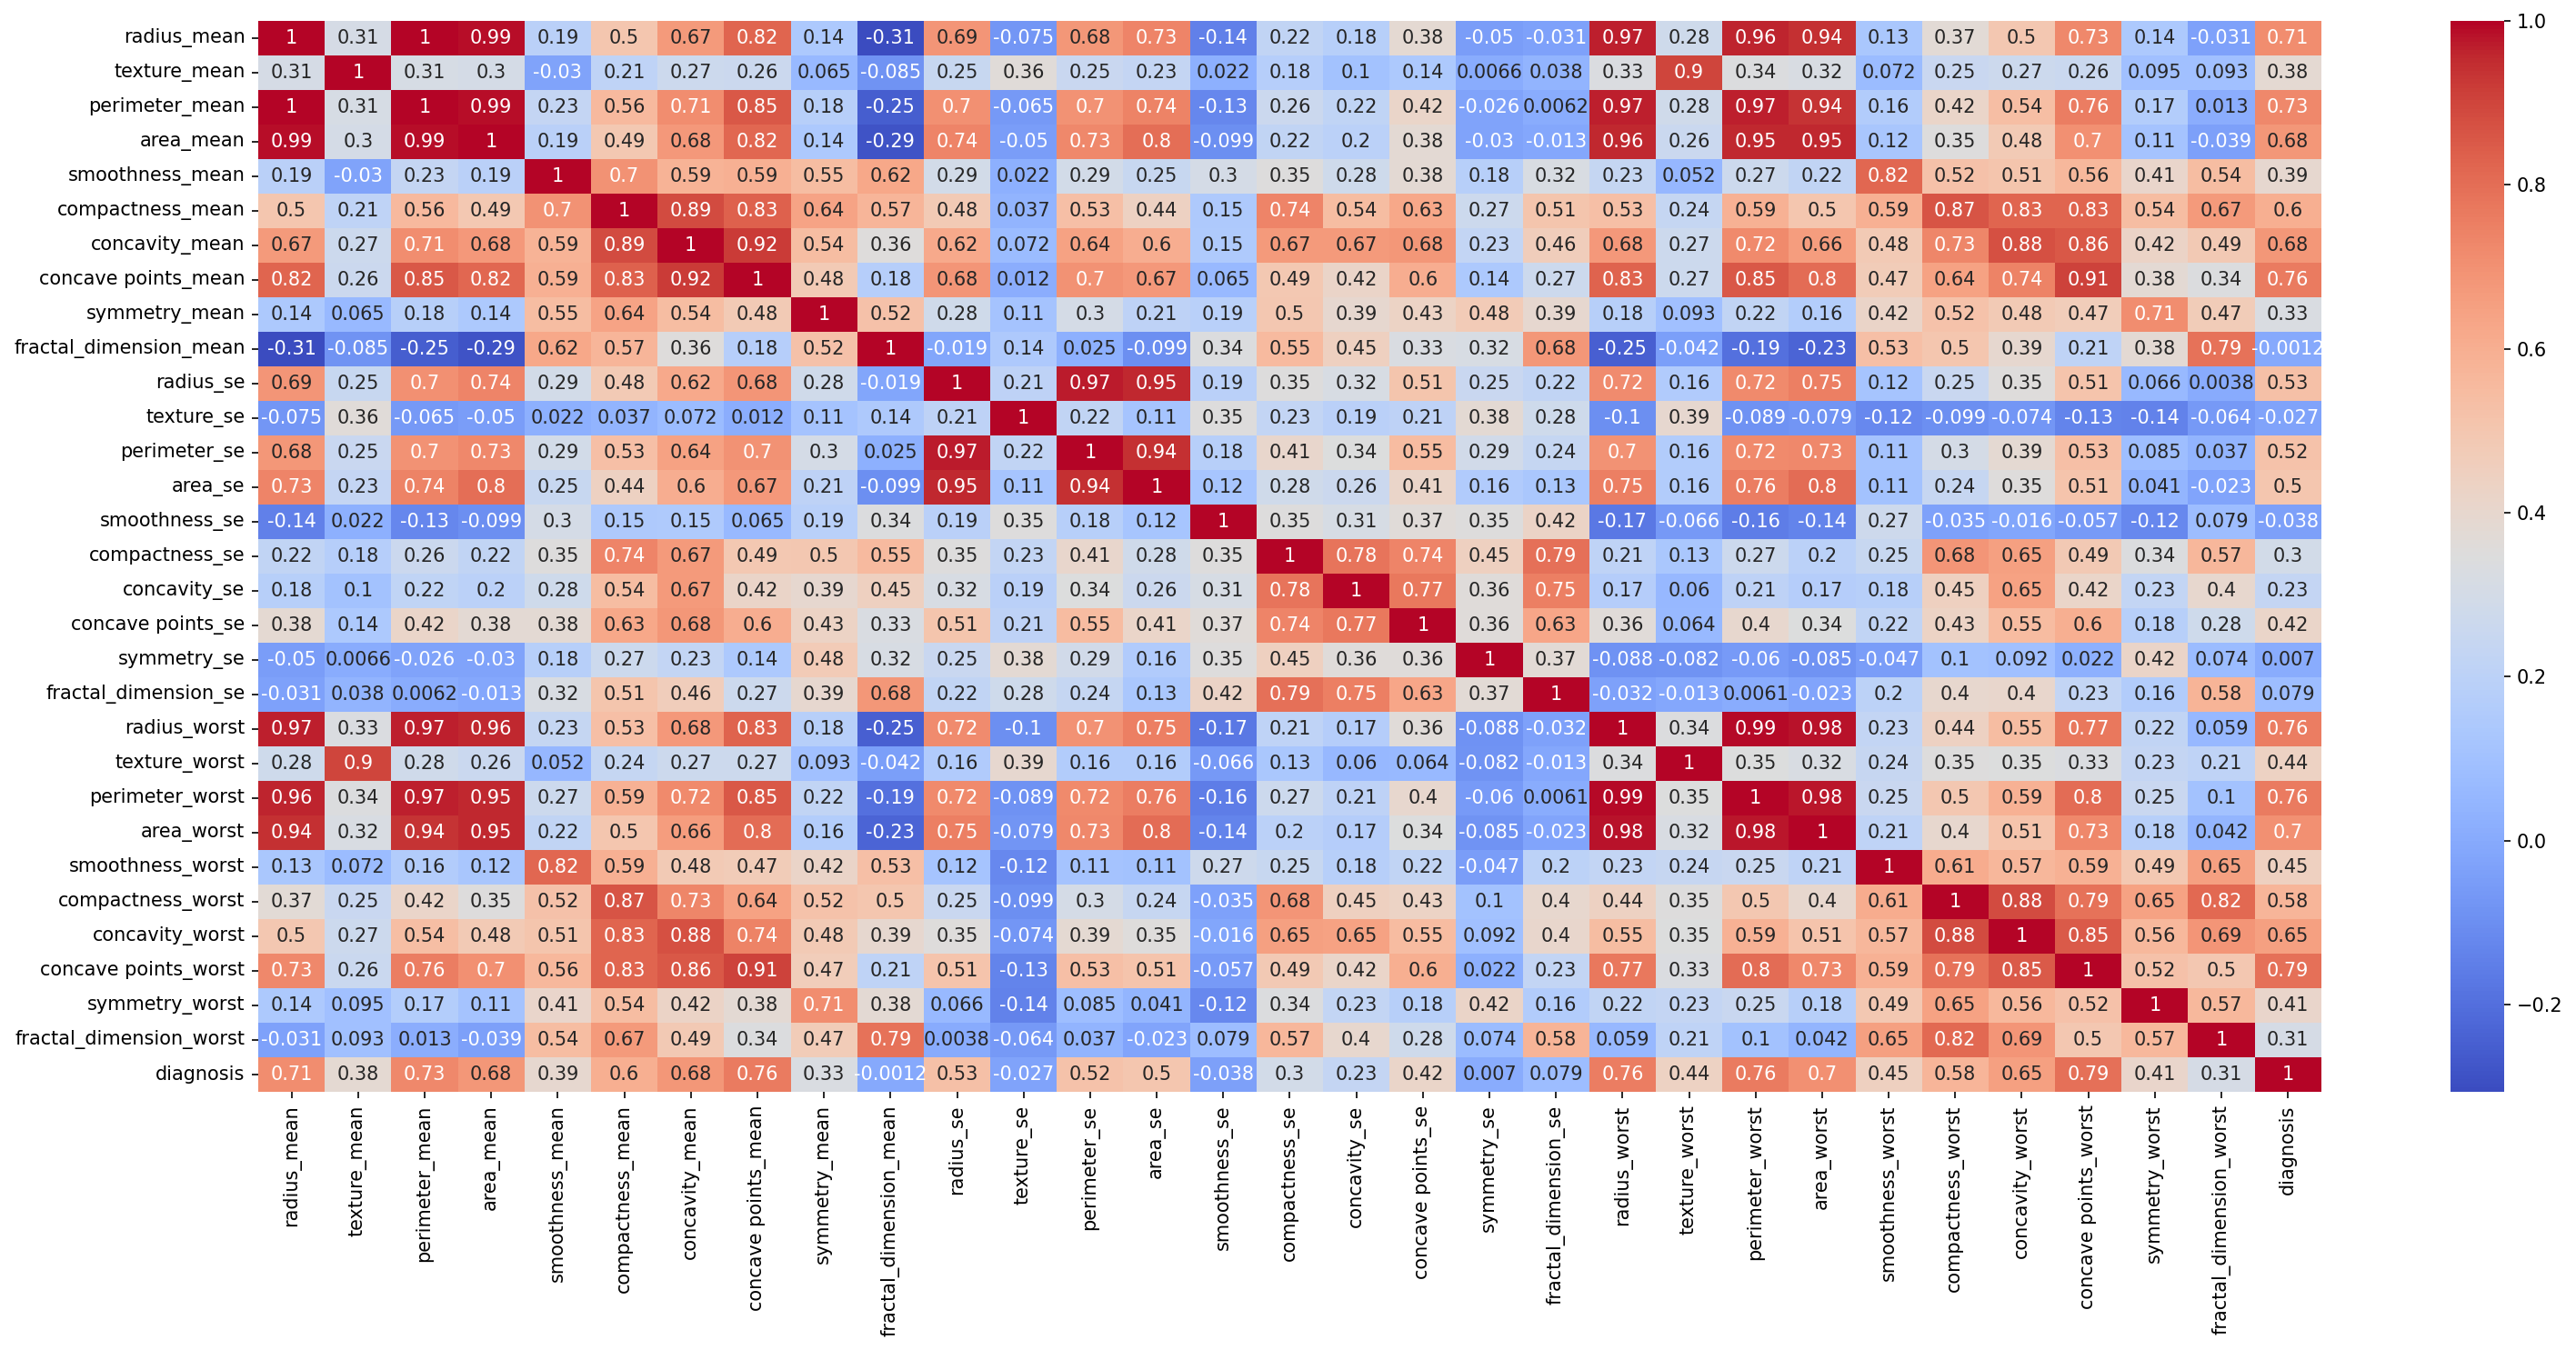

In [25]:
fig = plt.figure(figsize=(21, 10), dpi=150)
sns.heatmap(data=df_sampled.corr(), cbar=True, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

We could find out there are variable which can be explained by others, in addition, their correlations are basically 1 or tightly close to it. For instance, `perimeter_mean` can be calculated from `radius_mean` through $P = 2\pi R$, where R is the radius. Same situation happens for variables among `radius_worst`, `perimeter_worst`, and `area_worst` variables.

Thus, it is possible to infer there are variables can be derived from a primitive one through mathematic formulas or geometric relationships, in the list below, we can determine which of them will be dropped because they can introduce an error to our model.

For primitive `radius_mean`:

* `perimeter_mean`
* `area_mean`

For primtive `radius_worst`:

* `perimeter_worst`
* `area_worst`

and for primitive `radius_se`:
* `perimeter_se`
* `area_se`

In [73]:
df_sampled.drop(["perimeter_mean", "area_mean", "perimeter_worst", "area_worst", "perimeter_se", "area_se"], axis=1, inplace=True)

In [83]:
cor_target = df_sampled.corr()["diagnosis"].reset_index().rename(columns={"index":"features", "diagnosis":"correlation"})
cor_target_p = cor_target[cor_target.correlation > 0.5].sort_values(ascending=False, by="correlation")[1:]
cor_target_p

,features,correlation
21,concave points_worst,0.791105
5,concave points_mean,0.762324
16,radius_worst,0.755354
0,radius_mean,0.713202
4,concavity_mean,0.679539
20,concavity_worst,0.650440
3,compactness_mean,0.599911
19,compactness_worst,0.576074
8,radius_se,0.527539


In [76]:
# Define font style and palette for following plots.

from matplotlib.font_manager import FontProperties

font = FontProperties()
font.set_family("serif")
font.set_style("normal")
font.set_weight("normal")
palette_dict = {"pal1" : ["#C80036", "#0C1844"], "pal2": ["#373A40", "#DC5F00"], }

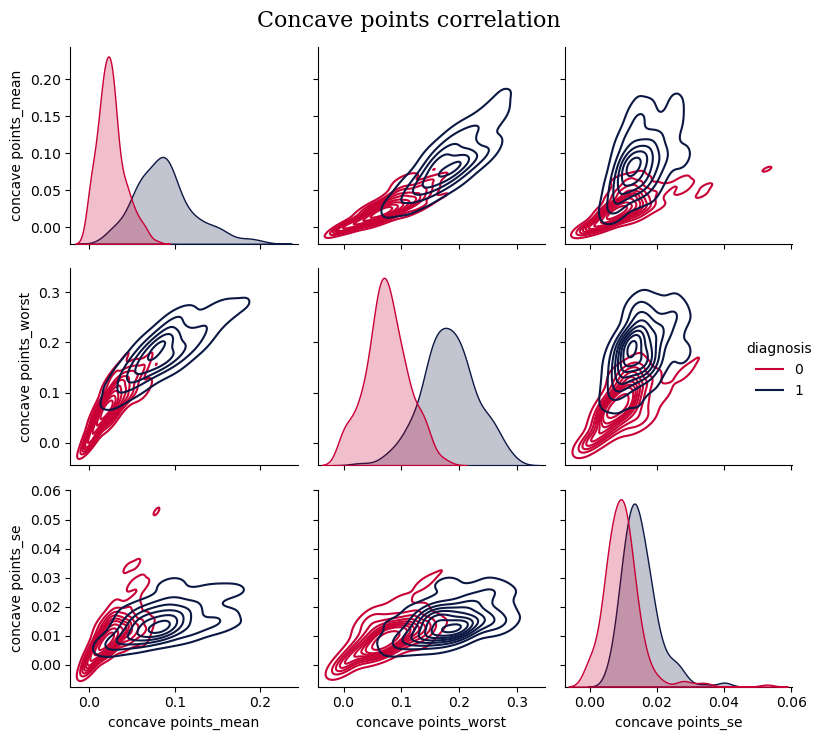

In [77]:
concave_points = sns.pairplot(data=df_sampled, vars=["concave points_mean", "concave points_worst", "concave points_se"], hue="diagnosis", kind="kde", palette=palette_dict["pal1"])
concave_points.figure.suptitle("Concave points correlation", fontsize=16, fontproperties=font)
plt.tight_layout()
plt.show()

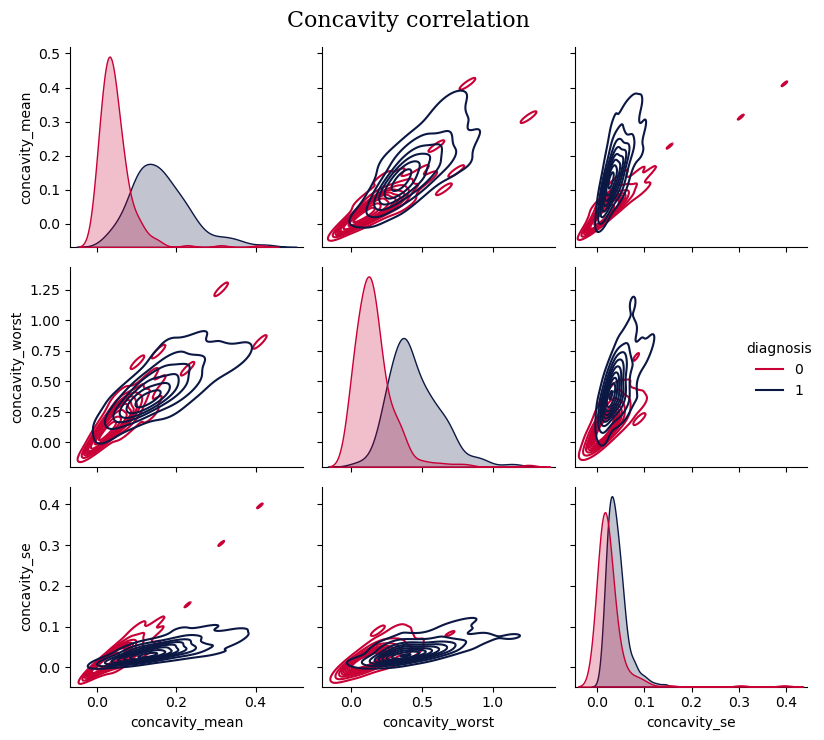

In [78]:
concavity = sns.pairplot(data=df_sampled, vars=["concavity_mean", "concavity_worst", "concavity_se"], hue="diagnosis", kind="kde", palette=palette_dict["pal1"])
concavity.figure.suptitle("Concavity correlation", fontsize=16, fontproperties=font)
plt.tight_layout()
plt.show()

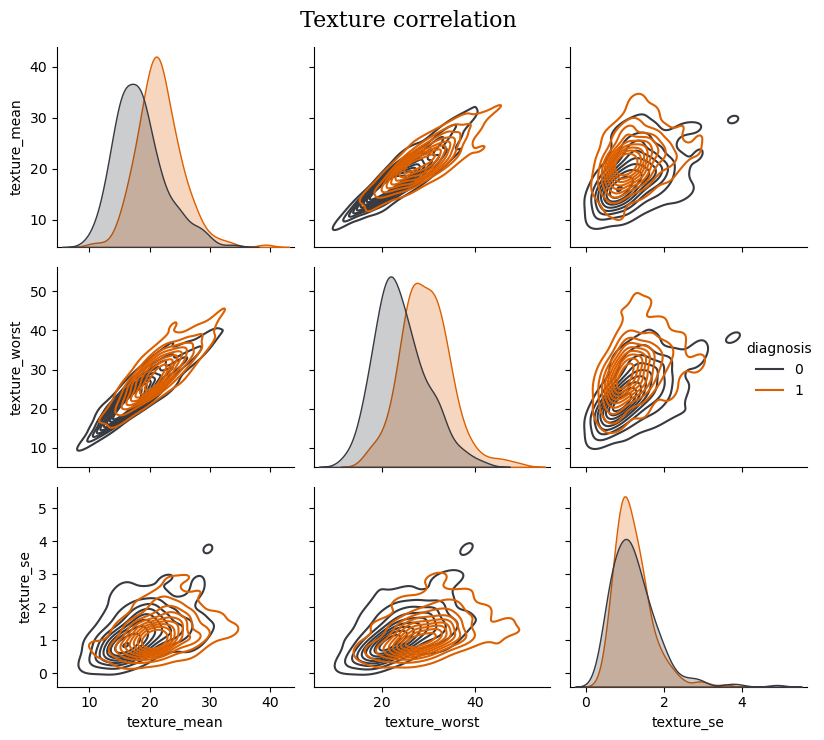

In [79]:
texture = sns.pairplot(data=df_sampled, vars=["texture_mean", "texture_worst", "texture_se"], hue="diagnosis", kind="kde", palette=palette_dict["pal2"])
texture.figure.suptitle("Texture correlation", fontsize=16, fontproperties=font)
plt.tight_layout()
plt.show()

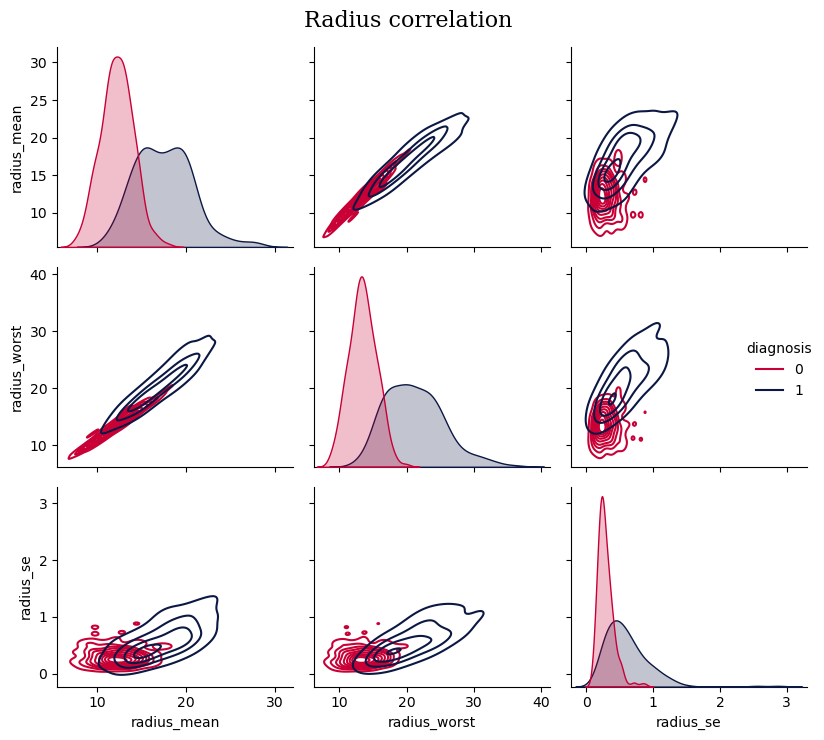

In [80]:
radius = sns.pairplot(data=df_sampled, vars=["radius_mean", "radius_worst", "radius_se"], hue="diagnosis", kind="kde", palette=palette_dict["pal1"])
radius.figure.suptitle("Radius correlation", fontsize=16, fontproperties=font)
plt.tight_layout()
plt.show()

Pairplots correlation for `radius`, `texture`, `concavity`, and `concavity points` depict span from slight to an appreciable shift of points to higher values when diagnosis marks for a positive value, this fact is also bolstered by correlation respect to target variable `diagnosis`, that we can observe in `cor_target_p`. Hence, these significative features will be used as input data to train the model.

Now, re defining `X_under` features to use them as predictors of target variable `diagnosis`:

In [87]:
cor_target_p.features.values.tolist()

['concave points_worst',
 'concave points_mean',
 'radius_worst',
 'radius_mean',
 'concavity_mean',
 'concavity_worst',
 'compactness_mean',
 'compactness_worst',
 'radius_se']

In [90]:
X_under = df_sampled.select_columns(
    [
        'concave points_worst',
        'concave points_mean',
        'radius_worst',
        'radius_mean',
        'concavity_mean',
        'concavity_worst',
        'compactness_mean',
        'compactness_worst',
        'radius_se'
 ]
)

### 5. Split and data scaling

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42, shuffle=True, test_size=0.2)
# Shuffle aids to allocate classes in a more even way.

In [93]:
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

### 6. Binomial class model

In [95]:
model = LogisticRegression(max_iter=10000, random_state=42) # For binomial analysis, let function use default binomial values.

In [96]:
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [99]:
predictions = model.predict(X_test)

In [104]:
cm = confusion_matrix(y_test, predictions)
accuracy_model = accuracy_score(y_test, predictions)
print(cm)
print(f"Accuracy score for this model is: {accuracy_model.round(4)}")

[[44  2]
 [ 0 39]]
Accuracy score for this model is: 0.9765


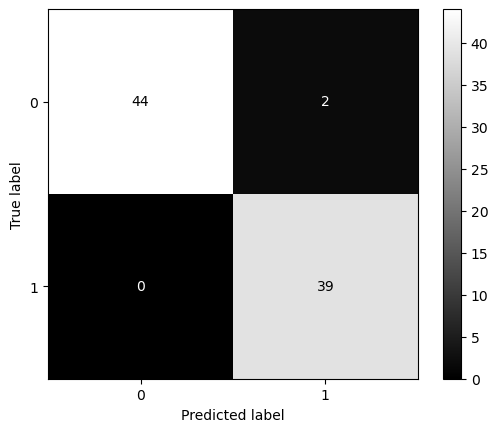

In [106]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="gray")
plt.show()

#### _Append 1_ - Analysis of weights:

In [120]:
weights = pd.Series(model.coef_[0], index=X_under.columns).reset_index().rename(columns={"index":"feature", 0:"weight"}, errors="coer").sort_values(ascending=False, by="weight")
labels = weights.feature.values.tolist()

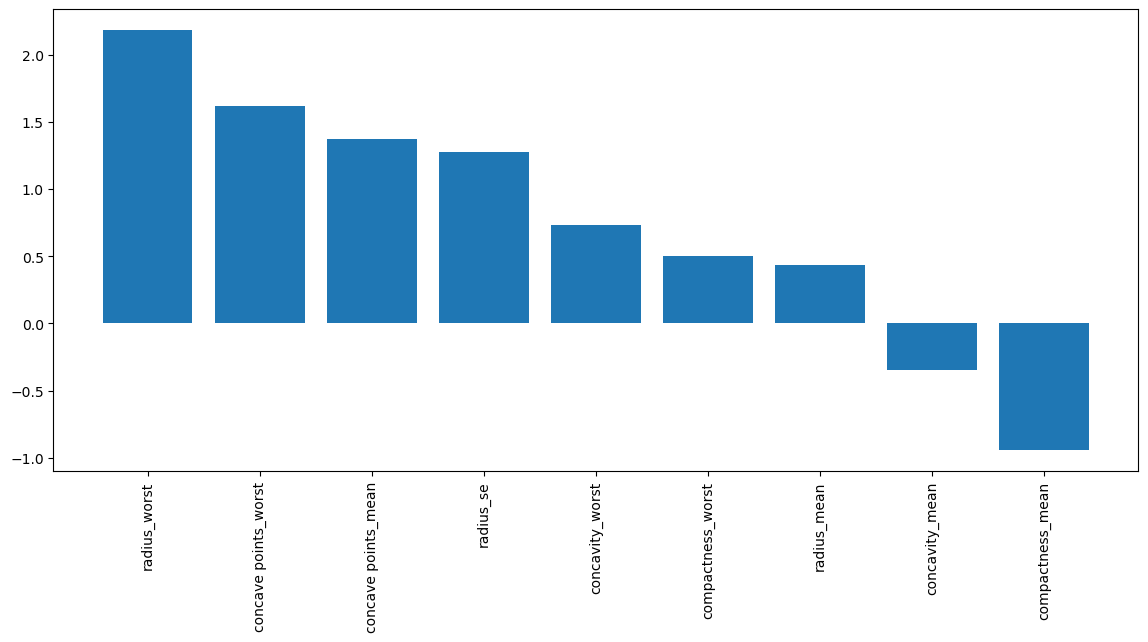

In [121]:
fig = plt.figure(figsize=(14,6))
plt.bar(data=weights, x="feature", height="weight")
plt.xticks(rotation=90, labels=labels, ticks=range(len(labels)))
plt.show()